In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sb
# actively reload module (during working on analyse_embeddings.py)
import importlib
import matplotlib.image as mpimg
import mat73
font = {'family' : 'sans-serif',
        #'fontname': 'Helvetica',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

### COLOR definitions ###
#colors of undistorted and distorted mesh
color_undist = np.array([97, 124, 154])/255
color_dist = np.array([238, 92, 67])/255

# for yaw, pitch and roll
colors_ypr = [ np.array([242, 153,  33])/255,
               np.array([224, 186, 215])/255,
               np.array([168, 198, 159])/255]

# for undistorted, add 1 add 3
colors_add1 =  np.array([132, 147, 36])/255
colors_add3 =  np.array([238, 92, 67])/255

colors_add1 = sb.blend_palette(['#2e6302','#a2b52c','#d3cb8f'],13)
colors_add3 = sb.blend_palette(['#e97222','#ee5c43','#ee7994'],13)

 #sb.color_palette("Oranges")


#f6bd60, #139a43, #0eb1d2, #805d93, #c05746


## FoV size of virtual frame
fov = [58, 58, 41, 39] # left, right, bottom, top extent of fov in degree


# Distortion overview
### Meshplot


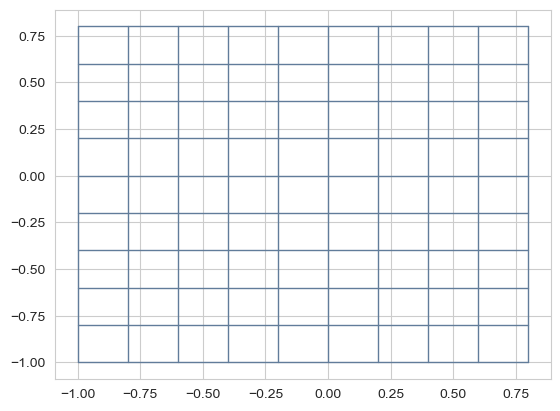

In [3]:
# function for plotting meshes
def meshplot(ax,x,y,clr,lw = 1.0):
    for k in range(y.shape[0]):
        ax.plot(x[k,:],y[k,:],color=clr,linewidth = lw)
    for k in range(x.shape[1]):
        ax.plot(x[:,k],y[:,k],color=clr,linewidth = lw)

[xm,ym] = np.meshgrid(np.arange(-1,1,0.2),np.arange(-1,1,0.2))

f,ax = plt.subplots()
meshplot(ax,xm,ym,color_undist)




../../mesh_input/SM-5A1/mesh.mat


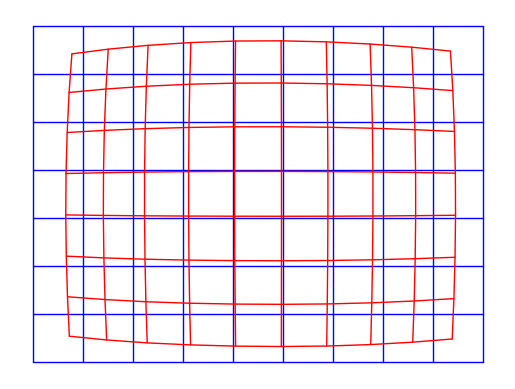

In [6]:
[x,y] = np.meshgrid(np.linspace(-1,1,10),np.linspace(-0.7,0.5,8))
lens_name = 'SM-5A1'

file_path = '../../mesh_input/' + lens_name + '/mesh.mat'
print(file_path)
mat = mat73.loadmat(file_path)
mesh_df = pd.DataFrame()
mesh_df['orig_x'] = mat['mesh_orig'][:,:,0].flatten()
mesh_df['orig_y'] = mat['mesh_orig'][:,:,1].flatten()
mesh_df['dist_x'] = mat['mesh_dist'][:,:,0].flatten()
mesh_df['dist_y'] = mat['mesh_dist'][:,:,1].flatten()

# clean up input by removing rows with at least one missing value
mesh_df = mesh_df.dropna()

#center distortion
xd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x'],(x,y),method='cubic') # TODO: check different interp options
yd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y'],(x,y),method='cubic') # TODO: check different interp options

f,ax = plt.subplots()
meshplot(ax,x,y,'b')
meshplot(ax,xd,yd,'r')
plt.axis('off')

plt.savefig('mesh_' + lens_name + '.svg', bbox_inches='tight', pad_inches = 0)

../../mesh_input/SM-5A3/mesh.mat


(-1.0999999999999999, 1.1, -1.0999999999999999, 1.0999999999999999)

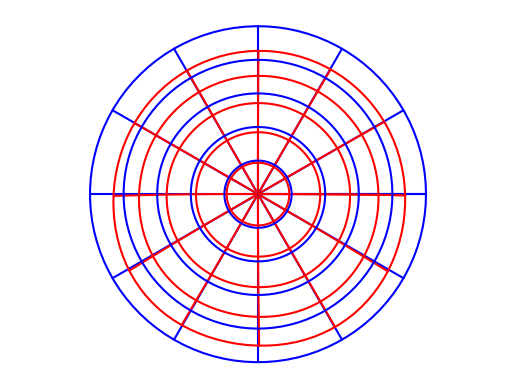

In [52]:
### polar meshplot

# read distortion dat
file_path = '../../mesh_input/' + 'SM-5A3' + '/mesh.mat'
print(file_path)
mat = mat73.loadmat(file_path)
mesh_df = pd.DataFrame()
mesh_df['orig_x'] = mat['mesh_orig'][:,:,0].flatten()
mesh_df['orig_y'] = mat['mesh_orig'][:,:,1].flatten()
mesh_df['dist_x'] = mat['mesh_dist'][:,:,0].flatten()
mesh_df['dist_y'] = mat['mesh_dist'][:,:,1].flatten()

# clean up input by removing rows with at least one missing value
mesh_df = mesh_df.dropna()

#center distortion
xc = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x'],(0,0),method='cubic') # TODO: check different interp options
yc = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y'],(0,0),method='cubic') # TODO: check different interp options

# meridians
phi = np.radians(range(0,361,30))
theta = np.radians(np.linspace(0,45,100))
for p in phi:
    x1 = np.tan(theta)*np.cos(p)
    y1 = np.tan(theta)*np.sin(p)
    plt.plot(x1,y1,'b')
    # distorted
    xd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x'],(x1,y1),method='cubic') # TODO: check different interp options
    yd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y'],(x1,y1),method='cubic')# TODO: check different interp options
    plt.plot(xd,yd,'r')


# circles
phi = np.radians(np.linspace(0,360,100))
theta = np.linspace(0,1,6)
for t in theta:
    x2 = t*np.cos(phi)
    y2 = t*np.sin(phi)
    plt.plot(x2,y2,'b')
    # distorted
    xd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x'],(x2,y2),method='cubic') # TODO: check different interp options
    yd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y'],(x2,y2),method='cubic') # TODO: check different interp options
    plt.plot(xd,yd,'r')

plt.axis('equal')
plt.axis('off')

## Distorted image

../../mesh_input/SM5A3/mesh.mat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


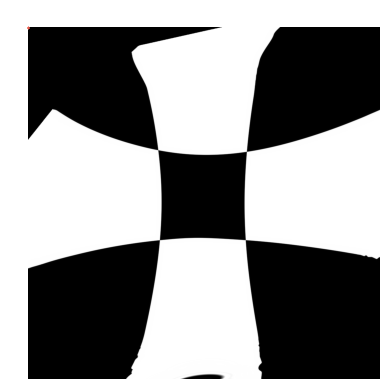

In [4]:
from scipy.ndimage import map_coordinates

# create sampling points in the resolution of the input image with world dimension given by x_lim and y_lim

# TODO: place pixels on 0.5,0.5
#  origin == 'upper' the default is (-0.5, numcols-0.5, numrows-0.5, -0.5).
#  For origin == 'lower' the default is (-0.5, numcols-0.5, -0.5, numrows-0.5).

#img = mpimg.imread('./distortion_overview/indoor2_hallway.jpg')
img = mpimg.imread('checkerboard.png')

file_path = '../../mesh_input/' + 'SM5A3' + '/mesh.mat'
print(file_path)
mat = mat73.loadmat(file_path)
mesh_df = pd.DataFrame()
mesh_df['orig_x'] = mat['mesh_orig'][:,:,0].flatten()
mesh_df['orig_y'] = mat['mesh_orig'][:,:,1].flatten()
mesh_df['dist_x'] = mat['mesh_dist'][:,:,0].flatten()
mesh_df['dist_y'] = mat['mesh_dist'][:,:,1].flatten()

# clean up input by removing rows with at least one missing value
mesh_df = mesh_df.dropna()

# predefine meshgrid for sampling points of 2d interpolation
xrange = np.linspace(-np.tan(np.radians(51.5)),np.tan(np.radians(51.5)),12)
yrange = np.linspace(-np.tan(np.radians(40)),np.tan(np.radians(40)),8)
[x,y] = np.meshgrid(xrange,yrange)

xrange = np.linspace(xrange[0],xrange[-1],img.shape[1])
yrange = np.linspace(yrange[0],yrange[-1],img.shape[0])
[xs,ys] = np.meshgrid(xrange,yrange)
ys = np.flipud(ys)

# interpolating image plane coordinates for defined sampling points
xu = sp.interpolate.griddata(mesh_df[['dist_x','dist_y']],mesh_df['orig_x'],(xs,ys),method='cubic') # TODO: check different interp options
yu = sp.interpolate.griddata(mesh_df[['dist_x','dist_y']],mesh_df['orig_y'],(xs,ys),method='cubic') # TODO: check different interp options

## transform (xu,y) from image plane space to pixel space (row,col)
im_col = (xu - xrange[ 0])/(xrange[-1] - xrange[0])*img.shape[1]
im_row = (-yu +yrange[-1])/(yrange[-1] - yrange[0])*img.shape[0]

# Interpolate the values for each color channel at the calculated coordinates
# We have to flatten the coordinates first and then reshape the 1d output for each channel
r_interpolated = map_coordinates(img[:,:,0], [im_row.flatten(),im_col.flatten()]).reshape(img.shape[0:2])
g_interpolated = map_coordinates(img[:,:,1], [im_row.flatten(),im_col.flatten()]).reshape(img.shape[0:2])
b_interpolated = map_coordinates(img[:,:,2], [im_row.flatten(),im_col.flatten()]).reshape(img.shape[0:2])

img_distorted = np.stack([r_interpolated, g_interpolated, b_interpolated], axis=-1) #  stack color channels at last dimension
plt.imshow(img_distorted)
plt.axis('off')
## meshplot on top
#plt.gca().invert_yaxis()
meshplot(plt.gca(),xm,ym,colors_add3[7])

In [26]:
img.shape

(4480, 6720, 3)

In [36]:
#plt.imshow(img_distorted,extent=(xrange[0],xrange[-1],yrange[0],yrange[-1]))
xd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x'],(x,y),method='cubic') # TODO: check different interp options
yd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y'],(x,y),method='cubic') # TODO: check different interp options
meshplot(plt.gca(),x,y,color_undist)
meshplot(plt.gca(),xd,yd,colors_add3[7])
plt.axis('off')
plt.savefig('mesh_example.svg')

NameError: name 'meshplot' is not defined

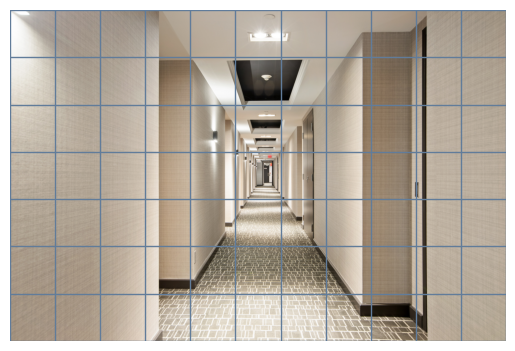

In [28]:
plt.imshow(img,extent=(xrange[0],xrange[-1],yrange[0],yrange[-1]))
meshplot(plt.gca(),x,y,color_undist)
plt.axis('off')
plt.savefig('mesh_undistorted.svg')

# Experiment procedure figure

../../mesh_input/SM5A3/mesh.mat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


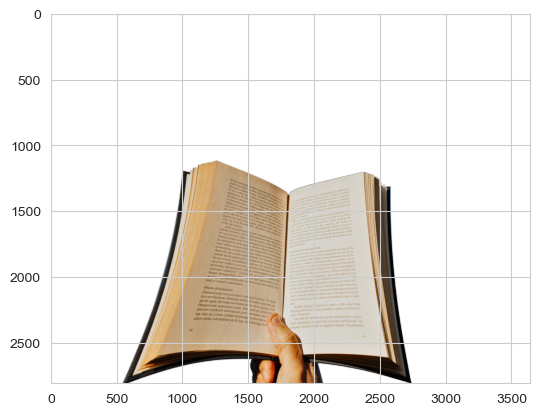

In [11]:
from scipy.ndimage import map_coordinates
#img = mpimg.imread('./vr_experiment/vr_scene120.png')
img = mpimg.imread('./fg_inFrame.png')
#lenses = ['SM2.5A3','SM-5A1','SM5A3']
lenses = ['SM5A3']
for lens in lenses:
    file_path = '../../mesh_input/' + lens + '/mesh.mat'
    print(file_path)
    mat = mat73.loadmat(file_path)
    mesh_df = pd.DataFrame()
    mesh_df['orig_x'] = mat['mesh_orig'][:,:,0].flatten()
    mesh_df['orig_y'] = mat['mesh_orig'][:,:,1].flatten()
    mesh_df['dist_x'] = mat['mesh_dist'][:,:,0].flatten()
    mesh_df['dist_y'] = mat['mesh_dist'][:,:,1].flatten()
    # clean up input by removing rows with at least one missing value
    mesh_df = mesh_df.dropna()

    # predefine meshgrid for sampling points of 2d interpolation
    fov_hor = 60
    fov_ver = img.shape[0]/img.shape[1]*fov_hor
    xrange = np.linspace(-np.tan(np.radians(fov_hor)),np.tan(np.radians(fov_hor)),12)
    yrange = np.linspace(-np.tan(np.radians(fov_ver)),np.tan(np.radians(fov_ver)),8)
    [x,y] = np.meshgrid(xrange,yrange)

    xrange = np.linspace(xrange[0],xrange[-1],img.shape[1])
    yrange = np.linspace(yrange[0],yrange[-1],img.shape[0])
    [xs,ys] = np.meshgrid(xrange,yrange)
    ys = np.flipud(ys)

    # interpolating image plane coordinates for defined sampling points
    xu = sp.interpolate.griddata(mesh_df[['dist_x','dist_y']],mesh_df['orig_x'],(xs,ys),method='cubic') # TODO: check different interp options
    yu = sp.interpolate.griddata(mesh_df[['dist_x','dist_y']],mesh_df['orig_y'],(xs,ys),method='cubic') # TODO: check different interp options

    ## transform (xu,y) from image plane space to pixel space (row,col)
    im_col = (xu - xrange[ 0])/(xrange[-1] - xrange[0])*img.shape[1]
    im_row = (-yu +yrange[-1])/(yrange[-1] - yrange[0])*img.shape[0]

    # Interpolate the values for each color channel at the calculated coordinates
    # We have to flatten the coordinates first and then reshape the 1d output for each channel
    r_interpolated = map_coordinates(img[:,:,0], [im_row.flatten(),im_col.flatten()]).reshape(img.shape[0:2])
    g_interpolated = map_coordinates(img[:,:,1], [im_row.flatten(),im_col.flatten()]).reshape(img.shape[0:2])
    b_interpolated = map_coordinates(img[:,:,2], [im_row.flatten(),im_col.flatten()]).reshape(img.shape[0:2])
    a_interpolated = map_coordinates(img[:,:,3], [im_row.flatten(),im_col.flatten()]).reshape(img.shape[0:2])
    img_distorted = np.stack([r_interpolated, g_interpolated, b_interpolated,a_interpolated], axis=-1) #  stack color channels at last dimension
    plt.imshow(img_distorted)
    from PIL import Image
    im = Image.fromarray(np.clip(img_distorted * 255, 0, 255).astype(np.uint8))
    #im.save('vr_scene_' + lens + '.png')
    im.save('fg_inFrame_' + lens + '.png')

### Ellipse Mask

In [15]:
def ellipse_mask(fov_imgplane):
    fov_radians = np.arctan(fov_imgplane)
    # calculate center and semi-axes for FoV ellipse
    fov_center = np.array([fov_imgplane[1] - fov_imgplane[0] ,  fov_imgplane[3] - fov_imgplane[2]])/2
    fov_axes = np.array([fov_imgplane[0] + fov_imgplane[1] ,  fov_imgplane[2] + fov_imgplane[3]])/2

    t = np.linscpace(0,2*np.pi,1000)
    x = fov_axes[0]*np.cos(t) + fov_center[0]
    y = fov_axes[1]*np.sin(t) + fov_center[1]

    # now calculate points relative to specified gaze direction
    return [x,y]

fov_imageplane = np.tan(np.radians(np.array([58 , 58 , 41 , 39])))
mask = ellipse_mask(fov_imageplane);

array([1.60033453, 1.60033453, 0.86928674, 0.80978403])

### Overview off all distortions

In [13]:
def distort_image(img,mesh_df,x_lim,y_lim):
    from scipy.ndimage import map_coordinates

    # create sampling points in the resolution of the input image with world dimension given by x_lim and y_lim
    xrange = np.linspace(x_lim[0],x_lim[-1],img.shape[1])
    yrange = np.linspace(y_lim[0],y_lim[-1],img.shape[0])
    [xs,ys] = np.meshgrid(xrange,yrange)
    ys = np.flipud(ys)

    # interpolating image plane coordinates for defined sampling points
    xu = sp.interpolate.griddata(mesh_df[['dist_x','dist_y']],mesh_df['orig_x'],(xs,ys),method='cubic') # TODO: check different interp options
    yu = sp.interpolate.griddata(mesh_df[['dist_x','dist_y']],mesh_df['orig_y'],(xs,ys),method='cubic') # TODO: check different interp options

    ## transform (xu,y) from image plane space to pixel space (row,col)
    im_col = (xu - xrange[ 0])/(xrange[-1] - xrange[0])*img.shape[1]
    im_row = (-yu +yrange[-1])/(yrange[-1] - yrange[0])*img.shape[0]

    # Interpolate the values for each color channel at the calculated coordinates
    # We have to flatten the coordinates first and then reshape the 1d output for each channel
    r_interpolated = map_coordinates(img[:,:,0], [im_row.flatten(),im_col.flatten()],mode = 'constant',cval=1.0).reshape(img.shape[0:2])
    g_interpolated = map_coordinates(img[:,:,1], [im_row.flatten(),im_col.flatten()],mode = 'constant',cval=1.0).reshape(img.shape[0:2])
    b_interpolated = map_coordinates(img[:,:,2], [im_row.flatten(),im_col.flatten()],mode = 'constant',cval=1.0).reshape(img.shape[0:2])

    img_distorted = np.stack([r_interpolated, g_interpolated, b_interpolated], axis=-1) #  stack color channels at last dimension

    return img_distorted

../../mesh_input/SM-5A1/mesh.mat
(xd,yd) interpolation for meshplot
../../mesh_input/SM-5A3/mesh.mat
(xd,yd) interpolation for meshplot
../../mesh_input/SM-2.5A1/mesh.mat
(xd,yd) interpolation for meshplot
../../mesh_input/SM-2.5A3/mesh.mat
(xd,yd) interpolation for meshplot
../../mesh_input/SM0A1/mesh.mat
(xd,yd) interpolation for meshplot
../../mesh_input/SM0A3/mesh.mat
(xd,yd) interpolation for meshplot
../../mesh_input/SM2.5A1/mesh.mat
(xd,yd) interpolation for meshplot
../../mesh_input/SM2.5A3/mesh.mat
(xd,yd) interpolation for meshplot
../../mesh_input/SM5A1/mesh.mat
(xd,yd) interpolation for meshplot
../../mesh_input/SM5A3/mesh.mat
(xd,yd) interpolation for meshplot


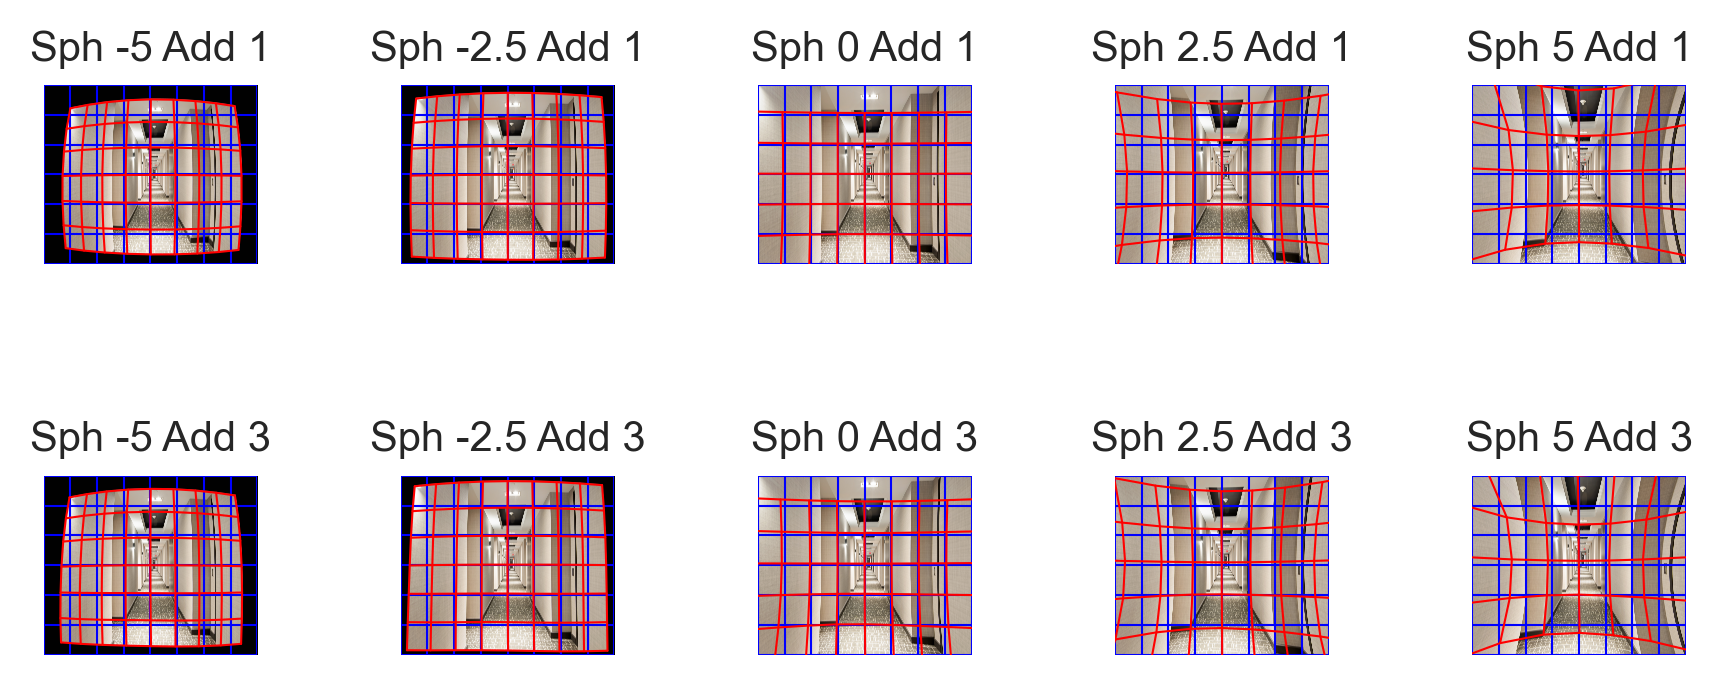

In [14]:
import matplotlib.image as mpimg
import scipy.ndimage # for image distortions
img = mpimg.imread('./distortion_overview/indoor2_hallway.jpg')

cm = 1/2.54
fig, ax = plt.subplots(2,5,figsize=(15.5*cm, 7*cm),dpi = 300)
plt.tight_layout()


# list of lenses and their corresponding refraction values
lens_list = ['SM-5A1','SM-5A3','SM-2.5A1','SM-2.5A3','SM0A1','SM0A3','SM2.5A1','SM2.5A3','SM5A1','SM5A3']
sph = [-5, -5, -2.5, -2.5, 0, 0, 2.5, 2.5, 5,5]
add = [1, 3, 1, 3, 1, 3, 1, 3, 1, 3]

# predefine meshgrid for sampling points of 2d interpolation
xrange = np.linspace(-np.tan(np.radians(50)),np.tan(np.radians(50)),9)
yrange = np.linspace(-np.tan(np.radians(45)),np.tan(np.radians(45)),7)
[x,y] = np.meshgrid(xrange,yrange)

# image transformation
xrange = np.linspace(-np.tan(np.radians(50)),np.tan(np.radians(50)),img.shape[1])
yrange = np.linspace(-np.tan(np.radians(45)),np.tan(np.radians(45)),img.shape[0])
[xs,ys] = np.meshgrid(xrange,yrange)

fov = [58, 58, 41, 39] # left, right, bottom, top extent of fov in degree
fov_imgplane = np.tan(np.radians(fov))

fov_center = np.array([fov_imgplane[1] - fov_imgplane[0] , fov_imgplane[3] - fov_imgplane[2]])/2
fov_axes = np.array([fov_imgplane[0] + fov_imgplane[1] , fov_imgplane[2] + fov_imgplane[3]])/2

theta = np.linspace(0,2*np.pi,2000)
x_ellipse = fov_axes[0] * np.cos(theta) + fov_center[0]
y_ellipse = fov_axes[1] * np.sin(theta) + fov_center[1]

for col in range(5):
    for row in range(2):
        lens_index = col*2 + row
        file_path = '../../mesh_input/' + lens_list[lens_index] + '/mesh.mat'
        print(file_path)
        mat = mat73.loadmat(file_path)
        mesh_df = pd.DataFrame()
        mesh_df['orig_x'] = mat['mesh_orig'][:,:,0].flatten()
        mesh_df['orig_y'] = mat['mesh_orig'][:,:,1].flatten()
        mesh_df['dist_x'] = mat['mesh_dist'][:,:,0].flatten()
        mesh_df['dist_y'] = mat['mesh_dist'][:,:,1].flatten()

        # clean up input by removing rows with at least one missing value
        mesh_df = mesh_df.dropna()
        # interpolation of forward transformation: find distorted point(xd,yd) for undistorted sampling point (xs,ys)
        print('(xd,yd) interpolation for meshplot')
        xd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x'],(x,y),method='cubic') # TODO: check different interp options
        yd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y'],(x,y),method='cubic') # TODO: check different interp options

        img_distorted = distort_image(img,mesh_df,[xrange[0],xrange[-1]] ,[yrange[0],yrange[-1]])

        ax[row,col].imshow(np.flipud(img_distorted),origin='lower',extent=(xrange[0],xrange[-1],yrange[0],yrange[-1]))
        meshplot(ax[row,col],x,y,'blue',lw = 0.5)
        meshplot(ax[row,col],xd,yd,'red',lw = 0.5)

        ax[row,col].set_title('Sph ' + str(sph[lens_index]) + ' Add ' + str(add[lens_index]),fontdict = font)
        ax[row,col].set_xlim([xrange[0],xrange[-1]])
        ax[row,col].set_ylim([yrange[0],yrange[-1]])
        ax[row,col].axis('off')
        ax[row,col].set_aspect('equal')

plt.savefig('distortion_overview.pdf', bbox_inches='tight', pad_inches = 0)

## Optic flow
Compare influence of distortions on optic flow for straight, head movement
Maybe also influence on scene statistics

(-2.2, 2.2, -1.65, 1.65)

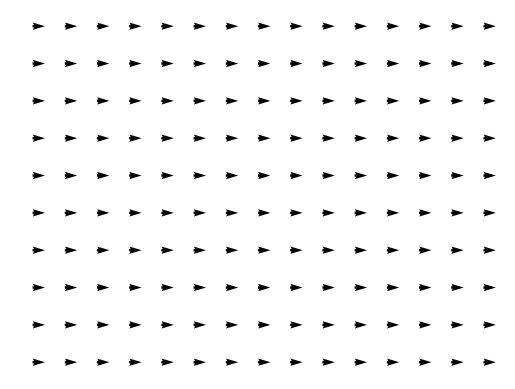

In [38]:
### Artifical distortions
[x,y] = np.meshgrid(np.linspace(-2,2,15),np.linspace(-1.5,1.5,10))
u = np.ones(x.shape)
v = np.zeros(x.shape)
k = 0.3

r = np.sqrt(x**2 + y**2)
phi = np.arctan2(y,x)
xd = x*(1 + k*r**2)
yd = y*(1 + k*r**2)
ud =  (1 + k*r**2 + x*k*x) * u + x*k*y * v
vd =  (1 + k*r**2 + y*k*y) * v + 4*y*k*x * u

#plt.contourf(x,y,1 + k*r**2,cmap='Reds',vmin = 1.1,vmax = 5)
plt.quiver(x,y,u,v,scale = 40)
plt.axis('off')


../../mesh_input/SM5A3/mesh.mat
(xu,yu) interpolation for meshplot


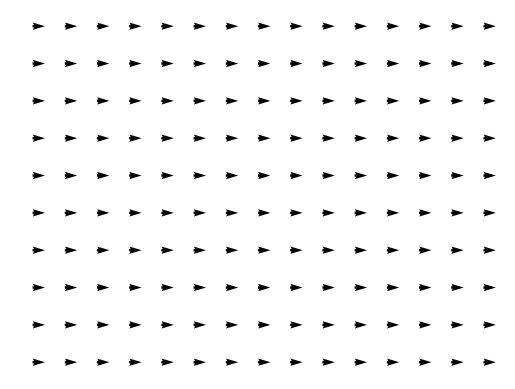

In [12]:
### Optic flow distorted with lens
[x,y] = np.meshgrid(np.linspace(-1.5,1.5,150),np.linspace(-1,1,100))
u = np.ones(x.shape)
v = np.zeros(x.shape)
k = 0.3

# calculate undistorted points for distorted (x,y)

file_path = '../../mesh_input/' + 'SM5A3' + '/mesh.mat'
print(file_path)
mat = mat73.loadmat(file_path)
mesh_df = pd.DataFrame()
mesh_df['orig_x'] = mat['mesh_orig'][:,:,0].flatten()
mesh_df['orig_y'] = mat['mesh_orig'][:,:,1].flatten()
mesh_df['dist_x'] = mat['mesh_dist'][:,:,0].flatten()
mesh_df['dist_y'] = mat['mesh_dist'][:,:,1].flatten()

# clean up input by removing rows with at least one missing value
mesh_df = mesh_df.dropna()
# interpolation of inverse transformation: find undistorted point(xu,yu) for undistorted sampling point (x,y)
print('(xu,yu) interpolation for meshplot')
xu = sp.interpolate.griddata(mesh_df[['dist_x','dist_y']],mesh_df['orig_x'],(x,y),method='cubic') # TODO: check different interp options
yu = sp.interpolate.griddata(mesh_df[['dist_x','dist_y']],mesh_df['orig_y'],(x,y),method='cubic') # TODO: check different interp options

## calculate derivative
dx = 0.05
# calculate Fx(x,y) and Fx(x+dx,y)
Fx_dx = (sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x'],(xu+dx,yu),method='cubic') - x)/dx
Fx_dy = (sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x'],(xu,yu+dx),method='cubic') - x)/dx
Fy_dx = (sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y'],(xu+dx,yu),method='cubic') - y)/dx
Fy_dy = (sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y'],(xu,yu+dx),method='cubic') - y)/dx

ud = Fx_dx * u + Fx_dy * v
vd = Fy_dx * u + Fy_dy * v

scale = np.sqrt((ud**2 + vd**2)/(u**2 + v**2))
#plt.contourf(x,y,scale,cmap='Reds',vmin = 1.1,vmax = 5)
plt.quiver(x[::10,::10],y[::10,::10],u[::10,::10],v[::10,::10],scale = 40)
#plt.quiver(x[::10,::10],y[::10,::10],ud[::10,::10],vd[::10,::10],scale = 40)
#plt.axes().set_aspect('equal')
plt.axis('off')

plt.savefig('optic_flow.svg')




## Upper vs lower FoV distortions

../../mesh_input/SM-5A1/mesh.mat
(xd,yd) interpolation
../../mesh_input/SM-5A3/mesh.mat
(xd,yd) interpolation
../../mesh_input/SM-2.5A1/mesh.mat
(xd,yd) interpolation
../../mesh_input/SM-2.5A3/mesh.mat
(xd,yd) interpolation


(-1.7, 1.7, -1.0, 1.0)

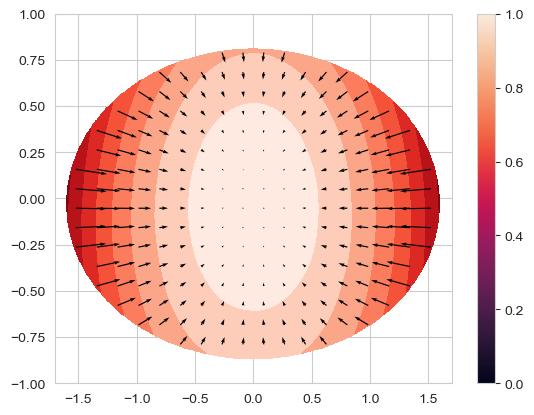

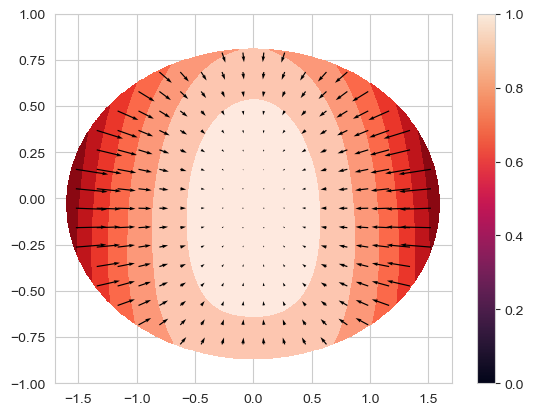

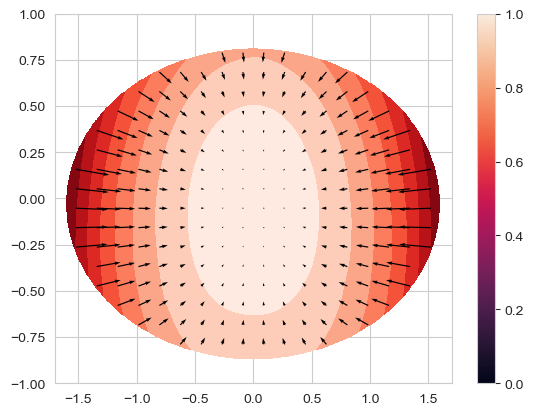

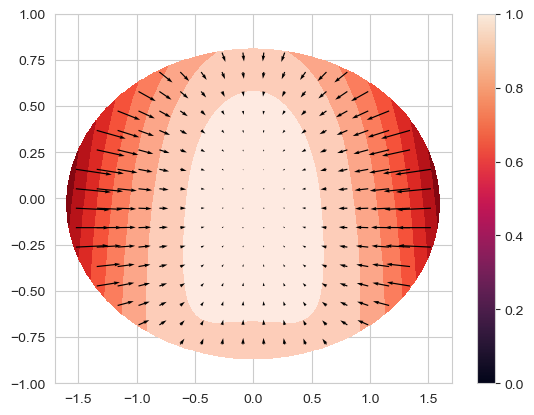

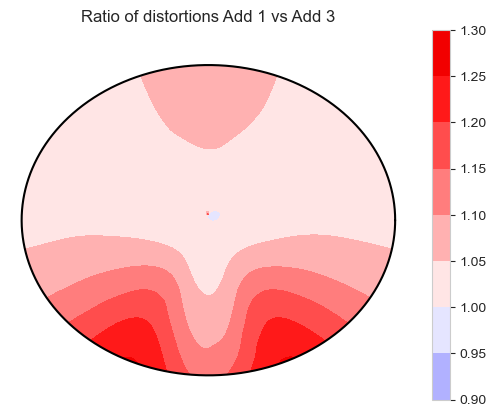

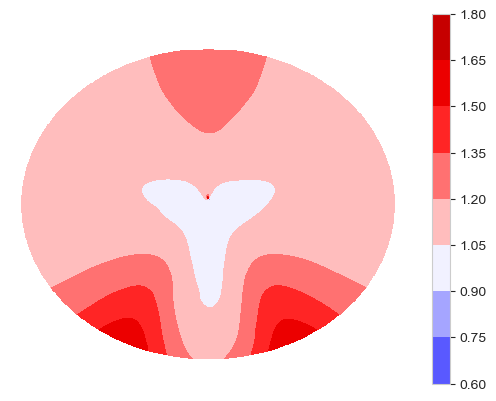

In [133]:
lens_list = ['SM-5A1','SM-5A3','SM-2.5A1','SM-2.5A3']
[x,y] = np.meshgrid(np.linspace(-1.7,1.7,10),np.linspace(-1.0,1.0,10))
[xs,ys] = np.meshgrid(np.linspace(-1.7,1.7,400),np.linspace(-1.0,1.0,400))
[xq,yq] = np.meshgrid(np.linspace(-1.7,1.7,20),np.linspace(-1.0,1.0,20))
fov_imgplane = np.tan(np.radians(fov))
fov_center = np.array([fov_imgplane[1] - fov_imgplane[0] , fov_imgplane[3] - fov_imgplane[2]])/2
fov_axes = np.array([fov_imgplane[0] + fov_imgplane[1] , fov_imgplane[2] + fov_imgplane[3]])/2
outside_mask = (xs - fov_center[0])**2 / fov_axes[0]**2 + (ys - fov_center[1])**2 / fov_axes[1]**2 > 1

outside_mask_quiver = (xq - fov_center[0])**2 / fov_axes[0]**2 + (yq - fov_center[1])**2 / fov_axes[1]**2 > 1
displacement = []

for lens in lens_list:
    file_path = '../../mesh_input/' + lens + '/mesh.mat'
    print(file_path)
    mat = mat73.loadmat(file_path)
    mesh_df = pd.DataFrame()
    mesh_df['orig_x'] = mat['mesh_orig'][:,:,0].flatten()
    mesh_df['orig_y'] = mat['mesh_orig'][:,:,1].flatten()
    mesh_df['dist_x'] = mat['mesh_dist'][:,:,0].flatten()
    mesh_df['dist_y'] = mat['mesh_dist'][:,:,1].flatten()

    # clean up input by removing rows with at least one missing value
    mesh_df = mesh_df.dropna()


    ## center interpolation
    xd_center = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x'],(0,0),method='cubic') # TODO: check different interp options
    yd_center = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y'],(0,0),method='cubic') # TODO: check different interp options

    # interpolation of forward transformation: find distorted point(xd,yd) for undistorted sampling point (xs,ys)
    print('(xd,yd) interpolation')
    xd_right = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x']-xd_center,(x,y),method='cubic') # TODO: check different interp options
    yd_right = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y']-yd_center,(x,y),method='cubic') # TODO: check different interp options

    xd_left = sp.interpolate.griddata((-mesh_df['orig_x'],mesh_df['orig_y']),-mesh_df['dist_x']+xd_center,(x,y),method='cubic') # TODO: check different interp options
    yd_left = sp.interpolate.griddata((-mesh_df['orig_x'],mesh_df['orig_y']),mesh_df['dist_y']-yd_center,(x,y),method='cubic') # TODO: check different interp options

    xd_sym = (xd_left + xd_right)/2
    yd_sym = (yd_left + yd_right)/2

    xd = sp.interpolate.griddata((x.flatten(),y.flatten()),xd_sym.flatten(),(xs,ys),method='cubic') # TODO: check different interp options
    yd = sp.interpolate.griddata((x.flatten(),y.flatten()),yd_sym.flatten(),(xs,ys),method='cubic') # TODO: check different interp options

    u =  sp.interpolate.griddata((x.flatten(),y.flatten()),xd_sym.flatten(),(xq,yq),method='cubic') # TODO: check different interp options
    v =  sp.interpolate.griddata((x.flatten(),y.flatten()),yd_sym.flatten(),(xq,yq),method='cubic') # TODO: check different interp options

    u[outside_mask_quiver] = np.nan
    v[outside_mask_quiver] = np.nan

    u = u - xq
    v = v - yq

    x_displ = xd - xs
    y_displ = yd - ys

    displ_norm = np.sqrt(x_displ**2 + y_displ**2)
    displ_norm[outside_mask] = np.nan

    displacement.append(displ_norm)

    #difference = displ_norm / np.flip
    #difference[outside_mask] = np.nan
    f = plt.figure()
    plt.contourf(xs,ys,displ_norm,cmap="Reds")
    plt.quiver(xq,yq,u,v)
    plt.colorbar()


f = plt.figure()
plt.contourf(xs,ys,displacement[0]/displacement[1],cmap="seismic",vmin = 0.5 , vmax = 1.5)
plt.colorbar()
theta = np.linspace(0,2*np.pi,2000)
x_ellipse = fov_axes[0] * np.cos(theta) + fov_center[0]
y_ellipse = fov_axes[1] * np.sin(theta) + fov_center[1]
plt.plot(x_ellipse,y_ellipse,'k')
plt.title("Ratio of distortions Add 1 vs Add 3")
plt.axis('off')
plt.savefig('distortion_ratio.pdf')


f = plt.figure()
plt.contourf(xs,ys,displacement[2]/displacement[3],cmap="seismic",vmin = 0 , vmax = 2)
plt.colorbar()

plt.axis('off')

## Scaling overview

In [1]:
scales_df = pd.read_pickle('../../data/scaling.pkl')
a = scales_df[(scales_df['add']==1)]
b = scales_df[(scales_df['add']==3)]

sb.color_palette("Set2")

fig, ax = plt.subplots(1,3)
fig.set_size_inches(14, 4)

plt.sca(ax[0])
sb.lineplot(
    data=a,
    x=a.sph, y="scaling", units="subj",hue='subj',palette=colors_add1,
    estimator=None, lw=0.5,alpha= 1,marker='o'
)
ax[0].set_title("Add: 1 dpt")

plt.sca(ax[1])
sb.lineplot(
    data=b,
    x="sph", y="scaling", units="subj",hue='subj',palette=colors_add3,
    estimator=None, lw=0.5,alpha= 1,marker='o'
)
ax[1].set_title("Add: 3 dpt")

plt.sca(ax[2])
sb.lineplot(data=a,x="sph", y="scaling",label='Add: 1 dpt',color=colors_add1[7]) #  [-2]
sb.lineplot(data=b,x="sph", y="scaling",label='Add: 3 dpt',color=colors_add3[7])
#sb.scatterplot(x=a.sph-0.07,y=a.scaling,marker='X',palette="Set2")
#sb.scatterplot(x=b.sph+0.07,y=b.scaling,marker='o',palette="Set2")

## add exponential fit
from scipy.optimize import curve_fit
def fit_fun(x, a, b, c):
    return a + b * c**x

fit1, fit1_cov = curve_fit(fit_fun, a.sph, a.scaling, [-0.75, 1, 1.1])
fit3, fit3_cov = curve_fit(fit_fun, b.sph, b.scaling, [-0.75, 1, 1.1])
x = np.linspace(a.sph.min()-1, a.sph.max()+1, 100)
plt.plot(x, fit1[0] + fit1[1] * fit1[2]**x, '--', alpha=0.8, c='grey')
plt.plot(x, fit3[0] + fit3[1] * fit3[2]**x, '--', alpha=0.8, c='grey')

# add text for fits
plt.text(-1, 0.4,f"${fit1[0]:.2f} + {fit1[1]:.2f} * {fit1[2]:.2f}^{{Sph}}$",rotation = 42)
plt.text(-1,-0.2,f"${fit3[0]:.2f} + {fit3[1]:.2f} * {fit3[2]:.2f}^{{Sph}}$",rotation = 42)

ax[0].set_xticks([-5,-2.5,0,2.5,5])
ax[1].set_xticks([-5,-2.5,0,2.5,5])
ax[2].set_xticks([-5,-2.5,0,2.5,5])
ax[2].set_title("Combined")

#plt.xticks([-5.1,-4.9,-2.6,-2.4,-0.1,0.1,2.4,2.6,4.9,5.1],
#            ["Add 1","Add 3","Add 1","Add 3","Add 1","Add 3","Add 1","Add 3","Add 1","Add 3"],rotation=90)

ax[0].xaxis.grid(False)
ax[1].xaxis.grid(False)
ax[2].xaxis.grid(False)

ax[0].get_legend().remove()
ax[1].get_legend().remove()


ax[0].set_ylim([-0.4,1.2])
ax[1].set_ylim([-0.4,1.2])
ax[2].set_ylim([-0.4,1.2])

ax[0].set_ylabel("Perceived distortions")
ax[1].set_ylabel("")
ax[2].set_ylabel("")

plt.xlabel("Sph (dpt)")

plt.savefig('scaling_overview.pdf')

NameError: name 'pd' is not defined

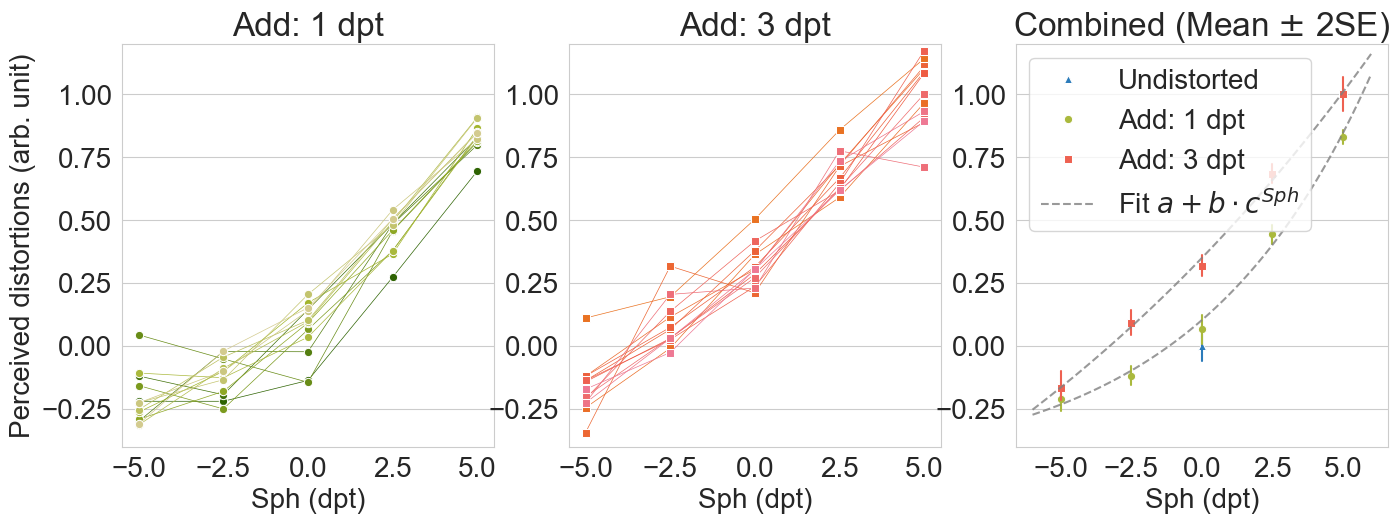

In [15]:
font = {'family' : 'sans-serif',
        #'fontname': 'Helvetica',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

scales_df = pd.read_pickle('../../data/scaling.pkl')
a = scales_df[(scales_df['add']==1)]
b = scales_df[(scales_df['add']==3)]
c = scales_df[(scales_df['add']==0)]

sb.color_palette("Set2")

fig, ax = plt.subplots(1,3)
fig.set_size_inches(16.3386, 5.23)

plt.sca(ax[0])
sb.lineplot(
    data=a,
    x=a.sph, y="scaling", units="subj",hue='subj',palette=colors_add1,
    estimator=None, lw=0.5,alpha= 1,marker='o'
)
ax[0].set_title("Add: 1 dpt")

plt.sca(ax[1])
sb.lineplot(
    data=b,
    x="sph", y="scaling", units="subj",hue='subj',palette=colors_add3,
    estimator=None, lw=0.5,alpha= 1,marker='s'
)
ax[1].set_title("Add: 3 dpt")

plt.sca(ax[2])
sb.lineplot(data=c,x="sph", y="scaling",label='Undistorted',err_style="bars",markers=True,marker='^', linestyle='',color='#2b7bba')
sb.lineplot(data=a,x="sph", y="scaling",label='Add: 1 dpt',err_style="bars",markers=True,marker='o', linestyle='',color=colors_add1[7]) #  [-2]
sb.lineplot(data=b,x="sph", y="scaling",label='Add: 3 dpt',err_style="bars",markers=True,marker='s', linestyle='',color=colors_add3[7])


#sb.scatterplot(x=a.sph-0.07,y=a.scaling,marker='X',palette="Set2")
#sb.scatterplot(x=b.sph+0.07,y=b.scaling,marker='o',palette="Set2")

## add exponential fit
from scipy.optimize import curve_fit
def fit_fun(x, a, b, c):
    return a + b * c**x

fit1, fit1_cov = curve_fit(fit_fun, a.sph, a.scaling, [-0.75, 1, 1.1])
fit3, fit3_cov = curve_fit(fit_fun, b.sph, b.scaling, [-0.75, 1, 1.1])
x = np.linspace(a.sph.min()-1, a.sph.max()+1, 100)
plt.plot(x, fit1[0] + fit1[1] * fit1[2]**x, '--', alpha=0.8, c='grey',label = 'Fit $a + b \cdot c^{Sph}$')
plt.plot(x, fit3[0] + fit3[1] * fit3[2]**x, '--', alpha=0.8, c='grey')
plt.legend()
# add text for fits
#plt.text(-1, 0.4,f"${fit1[0]:.2f} + {fit1[1]:.2f} * {fit1[2]:.2f}^{{Sph}}$",rotation = 42)
#plt.text(-1,-0.2,f"${fit3[0]:.2f} + {fit3[1]:.2f} * {fit3[2]:.2f}^{{Sph}}$",rotation = 42)

ax[0].set_xticks([-5,-2.5,0,2.5,5])
ax[1].set_xticks([-5,-2.5,0,2.5,5])
ax[2].set_xticks([-5,-2.5,0,2.5,5])
ax[2].set_title(r"Combined (Mean $\pm$ 2SE)")

#plt.xticks([-5.1,-4.9,-2.6,-2.4,-0.1,0.1,2.4,2.6,4.9,5.1],
#            ["Add 1","Add 3","Add 1","Add 3","Add 1","Add 3","Add 1","Add 3","Add 1","Add 3"],rotation=90)

ax[0].xaxis.grid(False)
ax[1].xaxis.grid(False)
ax[2].xaxis.grid(False)

ax[0].get_legend().remove()
ax[1].get_legend().remove()

ax[0].set_ylim([-0.4,1.2])
ax[1].set_ylim([-0.4,1.2])
ax[2].set_ylim([-0.4,1.2])

ax[0].set_ylabel("Perceived distortions (arb. unit)")
ax[0].set_xlabel("Sph (dpt)")
ax[1].set_xlabel("Sph (dpt)")
ax[2].set_xlabel("Sph (dpt)")
ax[1].set_ylabel("")
ax[2].set_ylabel("")

plt.savefig('scaling_overview.svg')

In [14]:
sb.color_palette("Greens")

[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),
 (0.7371472510572856, 0.895517108804306, 0.7108342945021145),
 (0.5573241061130334, 0.8164244521337947, 0.546958861976163),
 (0.3388235294117647, 0.7117262591311034, 0.40584390618992694),
 (0.17139561707035755, 0.581514801999231, 0.2979008073817762),
 (0.017762399077277974, 0.44267589388696654, 0.18523644752018453)]

C:\Users\Newton\AppData\Local\Temp\ipykernel_4612\655495322.py:10: UserWarning: 
The palette list has fewer values (6) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sb.lineplot(


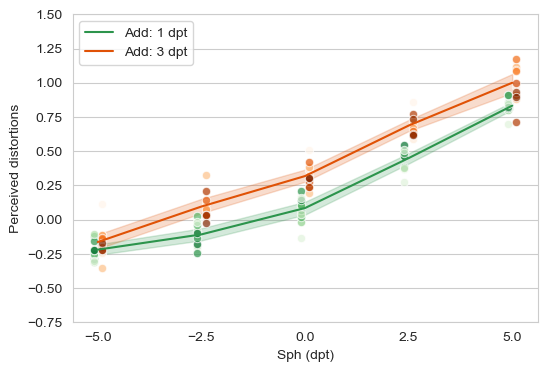

In [17]:
scales_df = pd.read_pickle('../../data/scaling.pkl')
a = scales_df[(scales_df['add']==1)]
b = scales_df[(scales_df['add']==3)]

sb.color_palette("Set2")

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)

sb.lineplot(
    data=a,
    x=a.sph-0.1, y="scaling", units="subj",hue='subj',palette=sb.color_palette("Greens"),
    estimator=None, lw=0,alpha= 0.7,marker='o',label='_nolegend_'
)
sb.lineplot(
    data=b,
    x=b.sph+0.1, y="scaling", units="subj",hue='subj',palette="Oranges",
    estimator=None, lw=0,alpha= 0.7,marker='o',label='_nolegend_'
)

sb.lineplot(data=a,x="sph", y="scaling",label='Add: 1 dpt',color=sb.color_palette("Greens")[-2])
sb.lineplot(data=b,x="sph", y="scaling",label='Add: 3 dpt',color=sb.color_palette("Oranges")[-2])
#sb.scatterplot(x=a.sph-0.07,y=a.scaling,marker='X',palette="Set2")
#sb.scatterplot(x=b.sph+0.07,y=b.scaling,marker='o',palette="Set2")

ax.set_xticks([-5,-2.5,0,2.5,5])
#plt.xticks([-5.1,-4.9,-2.6,-2.4,-0.1,0.1,2.4,2.6,4.9,5.1],
#            ["Add 1","Add 3","Add 1","Add 3","Add 1","Add 3","Add 1","Add 3","Add 1","Add 3"],rotation=90)

ax.xaxis.grid(False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[-2:], labels=labels[-2:])

ax.set_ylim([-0.75,1.5])
ax.set_ylabel("Perceived distortions")
plt.xlabel("Sph (dpt)")

plt.savefig('scaling_overview2.pdf')

## Behaviour

In [3]:
## Load all tracking data
# Load all subjects and calculate mean rotation vel

headmov_df = pd.DataFrame()
gaze_df = pd.DataFrame()

subj_list = [3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for subj in subj_list:
    #tracking_data = pd.read_pickle('../../data/' + str(subj).zfill(3) + 'filtered_tracking.pkl')
    tracking_trial_data = pd.read_pickle('../../data/' + str(subj).zfill(3) + 'trial_data.pkl')
    headmov_df = pd.concat([headmov_df,pd.DataFrame({'subj':[subj],
                                                     'mean_yaw':[tracking_trial_data.mean_yaw_vel.mean()],
                                                     'mean_pitch':[tracking_trial_data.mean_pitch_vel.mean()],
                                                     'mean_roll':[tracking_trial_data.mean_roll_vel.mean()]})])
    gaze_df = pd.concat([gaze_df,pd.DataFrame({'subj':[subj],
                                            'long':[tracking_trial_data.mean_c_gaze_long.mean()],
                                            'lat':[tracking_trial_data.mean_c_gaze_lat.mean()]})])


# Load example tracking data
subj = 4
tracking_data = pd.read_pickle('../../data/' + str(subj).zfill(3) + 'filtered_tracking.pkl')
subj = 3
tracking_trial_data = pd.read_pickle('../../data/' + str(subj).zfill(3) + 'trial_data.pkl')

In [4]:
headmov_df.reset_index().index

RangeIndex(start=0, stop=13, step=1)

In [9]:
headmov_df

,subj,mean_yaw,mean_pitch,mean_roll
0,3,3.425157,34.686567,3.381272
0,4,2.220876,17.845596,2.465277
0,5,2.966014,23.227862,2.849668
0,7,3.275828,29.251533,3.086079
0,8,2.262237,2.751562,1.763916
0,9,4.250378,4.520750,1.393217
0,10,6.638351,17.137588,3.352157
0,11,2.996846,2.320001,1.737033
0,12,27.868508,13.903750,5.911087
0,13,9.957392,6.234585,2.571108


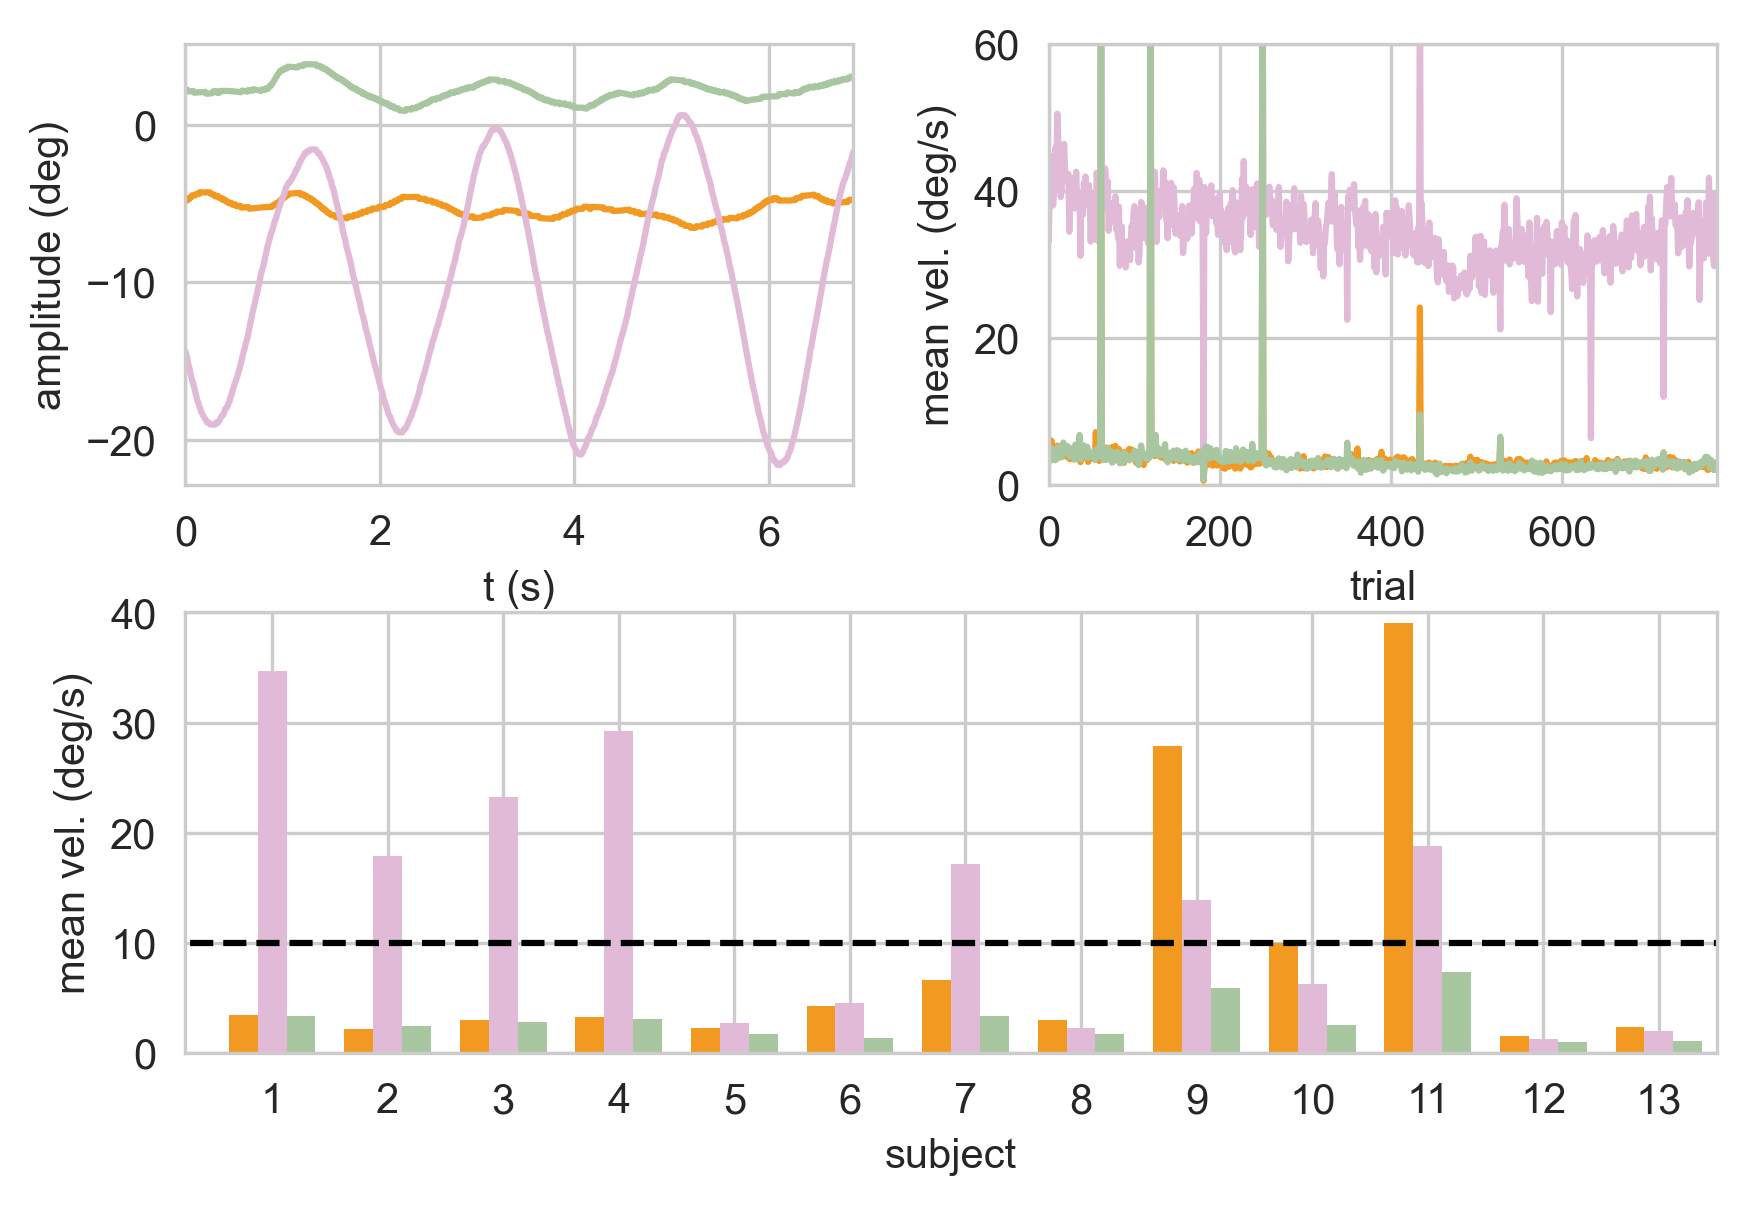

In [7]:
# plotting
cm = 1/2.54
fig, ax = plt.subplot_mosaic([['exmpl_trial','exmpl_subj'],['barplot','barplot']],figsize=(15*cm, 10*cm),dpi=300)
plt.tight_layout()


trial = 100
rep = 0
ind = (tracking_data.t == trial) & (tracking_data.rep == rep)
n_subj = headmov_df.reset_index().index.max() + 1
t0 = tracking_data.Timestamp[ind.idxmax()]
ax['exmpl_trial'].plot(tracking_data.Timestamp[ind]-t0,tracking_data.yaw[ind],label="yaw",color = colors_ypr[0])
ax['exmpl_trial'].plot(tracking_data.Timestamp[ind]-t0,tracking_data.pitch[ind],label="pitch",color = colors_ypr[1])
ax['exmpl_trial'].plot(tracking_data.Timestamp[ind]-t0,tracking_data.roll[ind],label="roll",color = colors_ypr[2])
#ax['exmpl_trial'].legend(ncol=3,bbox_to_anchor=(0.1, 1.05))
ax['exmpl_trial'].set_xlabel('t (s)')
ax['exmpl_trial'].set_ylabel('amplitude (deg)')
ax['exmpl_trial'].set_xlim([0,tracking_data.Timestamp[ind].max() - t0])

ax['exmpl_subj'].plot(tracking_trial_data.index,tracking_trial_data.mean_yaw_vel,color = colors_ypr[0])
ax['exmpl_subj'].plot(tracking_trial_data.index,tracking_trial_data.mean_pitch_vel,color = colors_ypr[1])
ax['exmpl_subj'].plot(tracking_trial_data.index,tracking_trial_data.mean_roll_vel,color = colors_ypr[2])
ax['exmpl_subj'].set_xlim([0,tracking_trial_data.index.max()])
ax['exmpl_subj'].set_ylim([0,60])
ax['exmpl_subj'].set_xlabel('trial')
ax['exmpl_subj'].set_ylabel('mean vel. (deg/s)')

width = 0.25  # the width of the bars
ax['barplot'].bar(headmov_df.reset_index().index +1 -width,headmov_df.mean_yaw,width,edgecolor= 'none',color = colors_ypr[0])
ax['barplot'].bar(headmov_df.reset_index().index +1,headmov_df.mean_pitch,width,edgecolor= 'none',color = colors_ypr[1])
ax['barplot'].bar(headmov_df.reset_index().index +1 +width,headmov_df.mean_roll,width,edgecolor= 'none',color = colors_ypr[2])

ax['barplot'].plot([0,n_subj+1], [10,10],'--',color='k')
ax['barplot'].set_xlim([width,n_subj + 2*width])
ax['barplot'].set_ylim([0,40])
ax['barplot'].set_xticks(range(1,n_subj+1))


plt.ylabel('mean vel. (deg/s)')
plt.xlabel('subject')

plt.savefig('head_behaviour.pdf', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('head_behaviour.svg', bbox_inches = 'tight', pad_inches = 0)

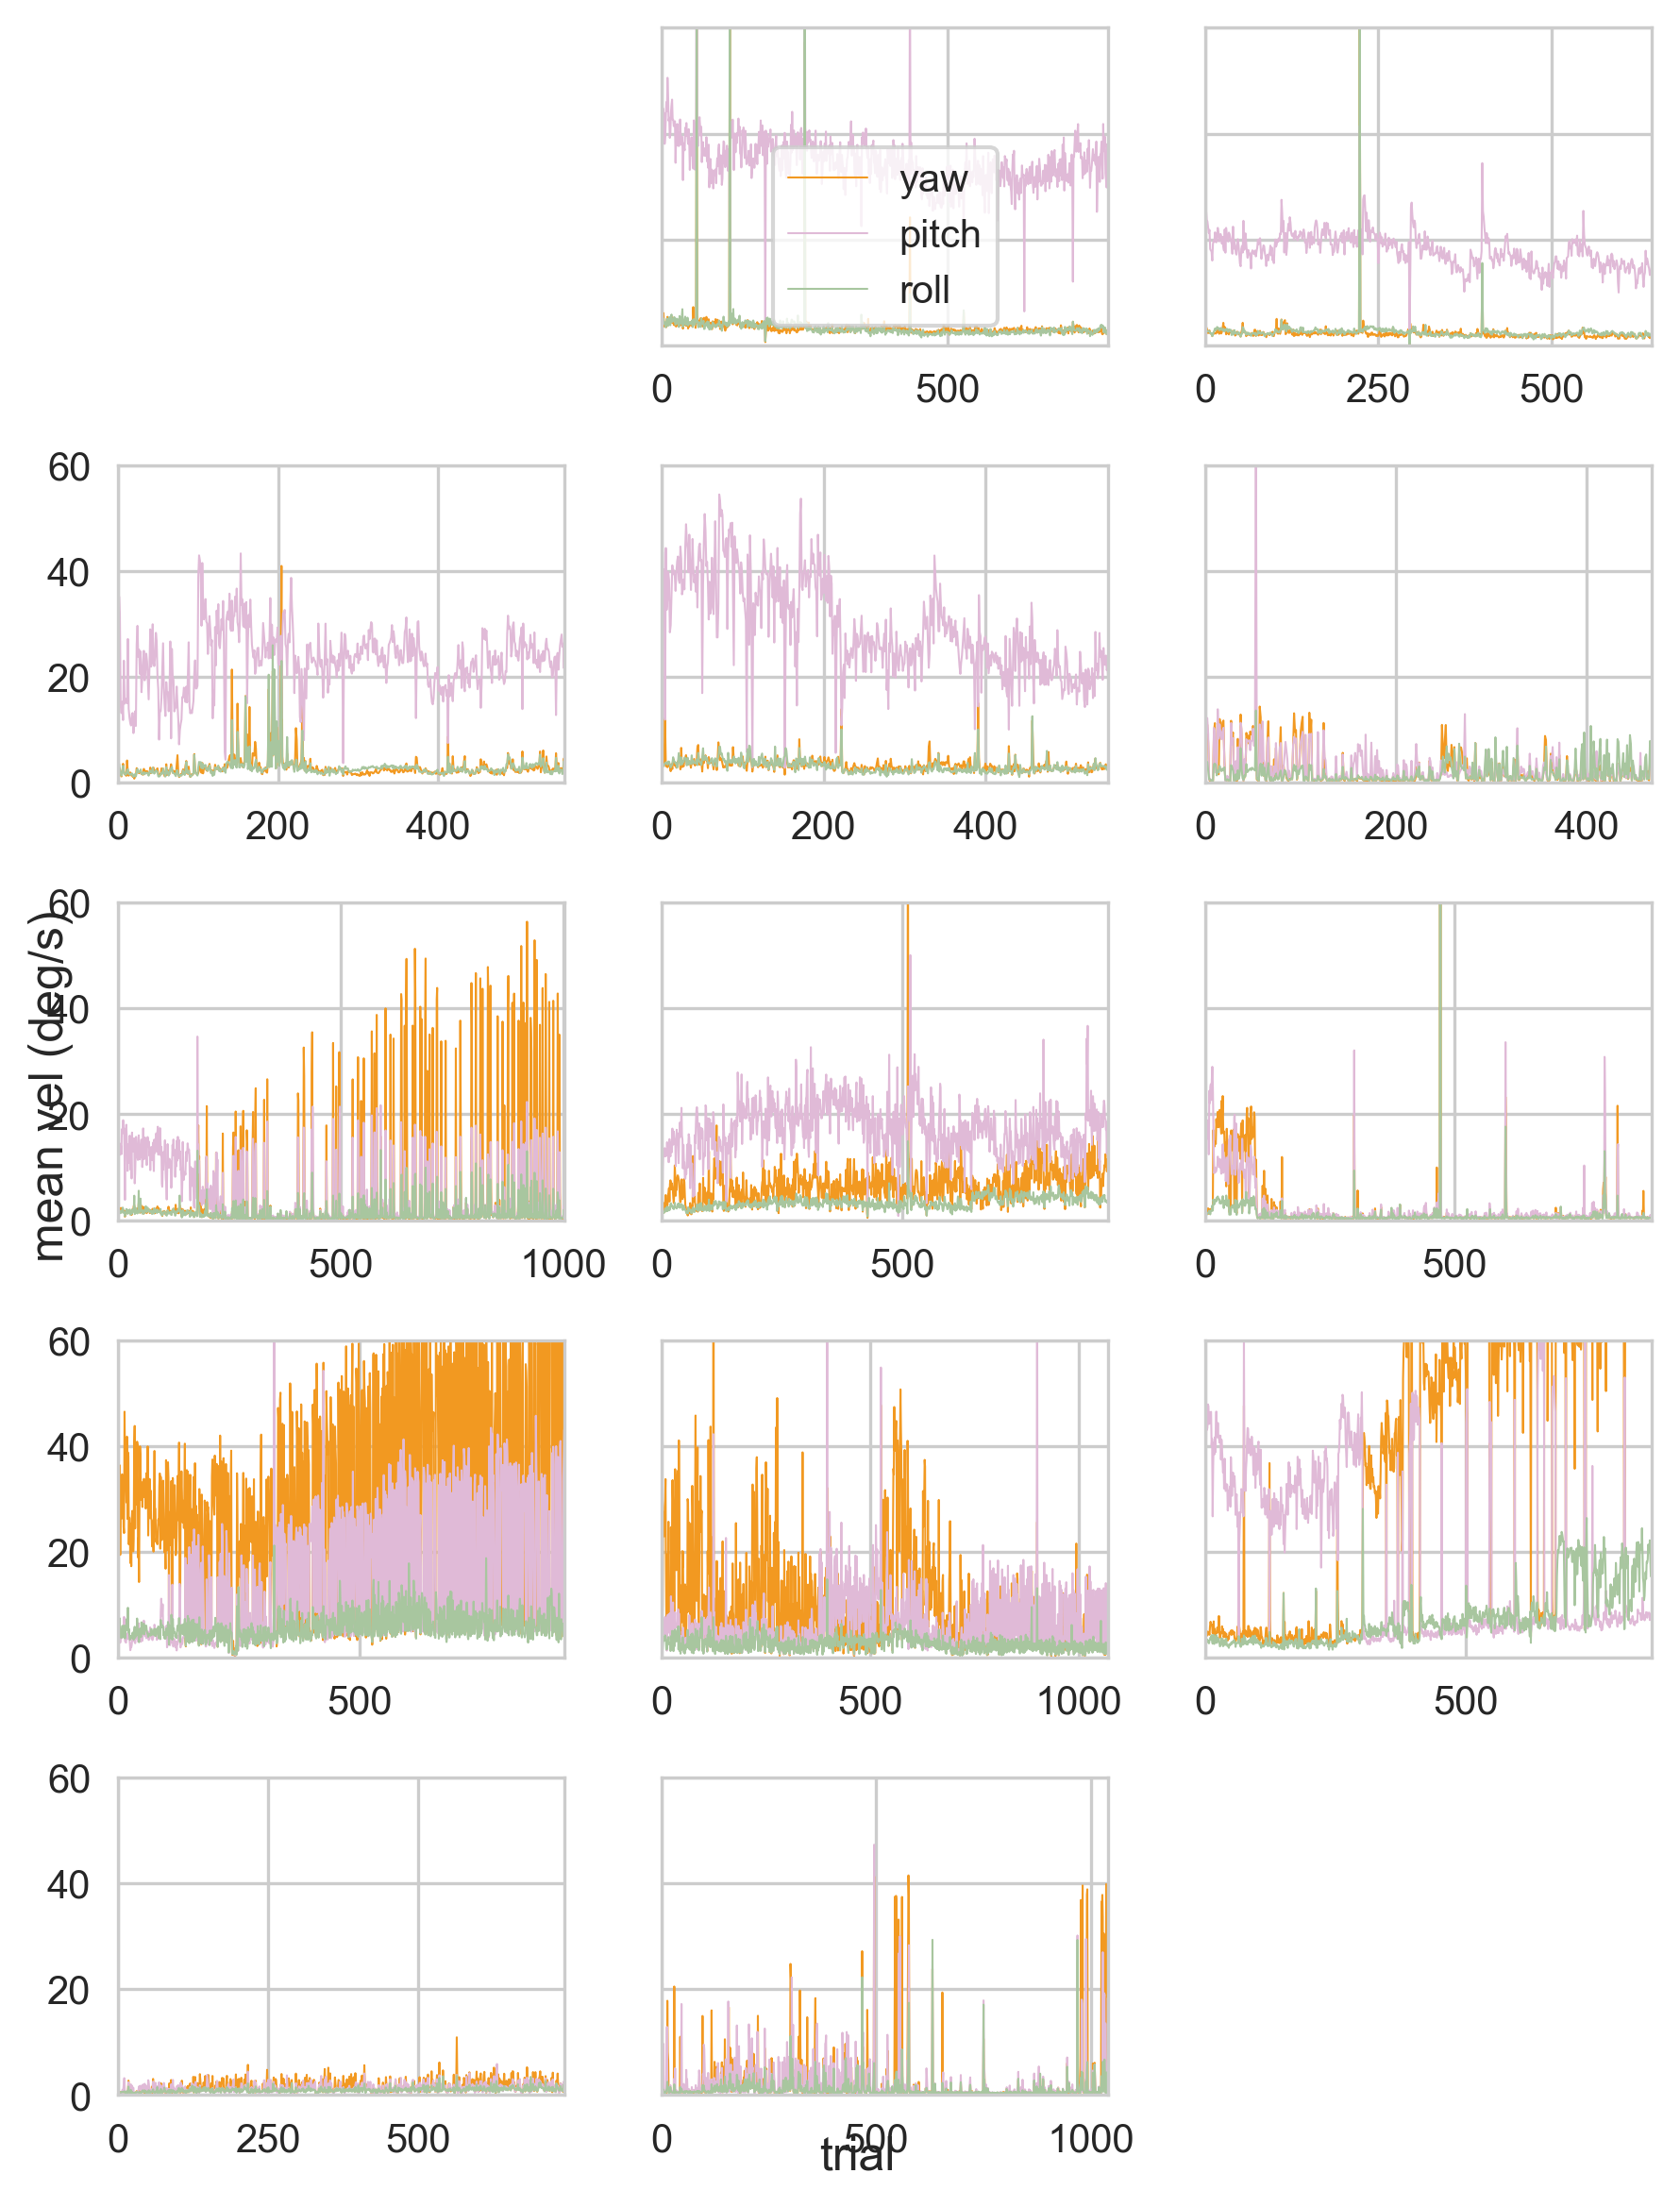

In [12]:
# plotting
cm = 1/2.54
fig, axs = plt.subplots(5,3,figsize=(15.5*cm, 20*cm),dpi=300,sharex=False, sharey=True)
plt.tight_layout()
subj_list = [3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
ax = axs.flatten()

for i in range(len(subj_list)):
    subj = subj_list[i]
    # load data from pickle
    tracking_data = pd.read_pickle('../../data/' + str(subj).zfill(3) + 'filtered_tracking.pkl')
    #tracking_data = tracking_data[0:1000].copy()
    tracking_trial_data = pd.read_pickle('../..'
                                         '/data/' + str(subj).zfill(3) + 'trial_data.pkl')
    ax[i+1].plot(tracking_trial_data.index,tracking_trial_data.mean_yaw_vel,color = colors_ypr[0],linewidth=0.5,label = 'yaw')
    ax[i+1].plot(tracking_trial_data.index,tracking_trial_data.mean_pitch_vel,color = colors_ypr[1],linewidth=0.5,label = 'pitch')
    ax[i+1].plot(tracking_trial_data.index,tracking_trial_data.mean_roll_vel,color = colors_ypr[2],linewidth=0.5,label = 'roll')
    ax[i+1].set_xlim([0,tracking_trial_data.index.max()])
    ax[i+1].set_ylim([0,60])
    #ax[i+1].set_xlabel('trial')
    #ax[i+1].set_ylabel('mean vel. (deg/s)')

ax[0].axis("off")
ax[1].legend()
ax[-1].axis("off")
fig.supxlabel('trial')
fig.supylabel('mean vel (deg/s)')
plt.savefig('individual_headmov.svg', bbox_inches='tight', pad_inches=0)


In [20]:
    def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    from matplotlib.patches import Ellipse
    from matplotlib.transforms import Affine2D
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

plotting subj  3
plotting subj  4
plotting subj  5
plotting subj  7
plotting subj  8
plotting subj  9
plotting subj  10
plotting subj  11
plotting subj  12
plotting subj  13
plotting subj  14
plotting subj  15
plotting subj  16


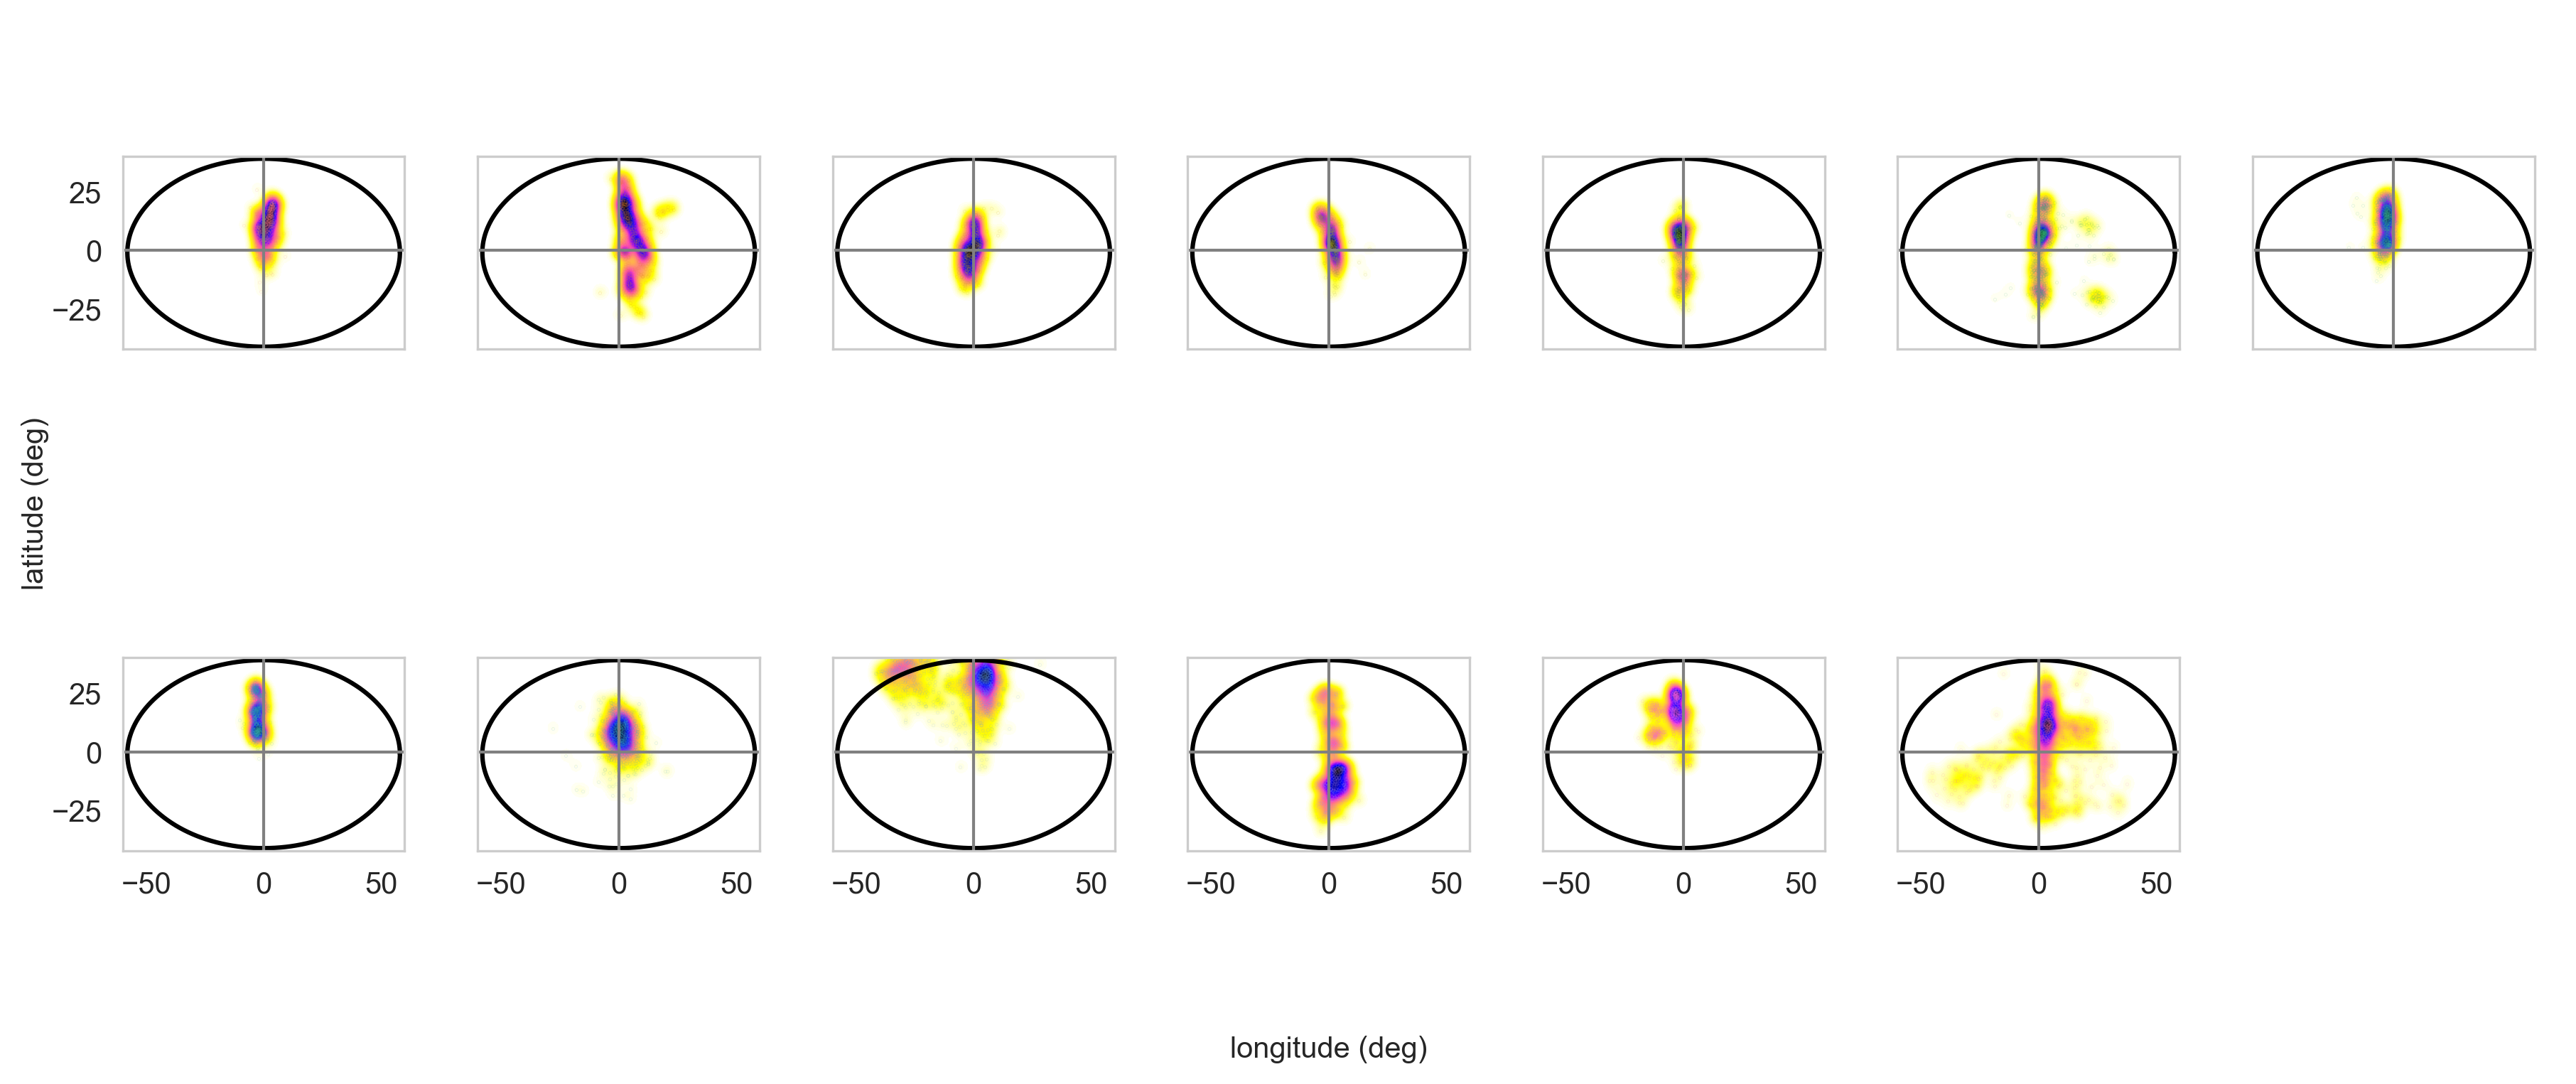

In [12]:
### Gaze distribution
import sys
sys.path.insert(0,'../../..')
import gaze3d
import importlib
importlib.reload(gaze3d) # in case we do changes to gaze3d
from scipy import stats


## prepare frame ellipse

fov = [58, 58, 41, 39] # left, right, bottom, top extent of fov in degree
fov_imgplane = np.tan(np.radians(fov))
fov_center = np.array([fov_imgplane[1] - fov_imgplane[0] , fov_imgplane[3] - fov_imgplane[2]])/2
fov_axes = np.array([fov_imgplane[0] + fov_imgplane[1] , fov_imgplane[2] + fov_imgplane[3]])/2

theta = np.linspace(0,2*np.pi,2000)
x_ellipse = fov_axes[0] * np.cos(theta) + fov_center[0]
y_ellipse = fov_axes[1] * np.sin(theta) + fov_center[1]
z_ellipse = np.ones(x_ellipse.shape)
r,long_ellipse,lat_ellipse = gaze3d.cart2geographic(x_ellipse,y_ellipse,z_ellipse)

fig, axs = plt.subplots(2,7,sharex=True, sharey=True,figsize=(12, 5), dpi=300)
plt.tight_layout()

subj_list = [3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
colors = sb.color_palette("husl", len(subj_list))
counter = 0
for subj in subj_list:
    print('plotting subj ' , str(subj))
    ax = plt.subplot(2,7,1+counter)
    plt.grid(visible=None)

    #tracking_data = pd.read_pickle('../../data/' + str(subj).zfill(3) + 'filtered_tracking.pkl')
    tracking_trial_data = pd.read_pickle('../../data/' + str(subj).zfill(3) + 'trial_data.pkl')
    x = np.degrees(tracking_trial_data.mean_c_gaze_long)
    y = np.degrees(tracking_trial_data.mean_c_gaze_lat)
    ind = ~np.isnan(x)
    x = x[ind]
    y = y[ind]
    ind = ~np.isnan(y)
    x = x[ind]
    y = y[ind]
    subj_color = colors[counter] + (0.5,) # add 0.5 transparency
    ax.scatter(x, y,color = subj_color,s= 0.01,marker='.',alpha = 0.5)
    X, Y = np.mgrid[slice(-60,60,0.5),slice(-42,40,0.5)]
    #img_kde = gaze3d.kde_long_lat(x,y,1,X,Y)
    ######
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(metric='haversine', bandwidth=np.radians(2))
    xtrain = np.vstack([np.radians(x),np.radians(y)]).T
    kde.fit(xtrain)
    xsampl = np.radians(np.vstack([X.ravel(),Y.ravel()]).T)
    img_kde = np.exp(kde.score_samples(xsampl))
    img_kde = img_kde.reshape(X.shape)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#00000000",subj_color,subj_color])
    cmap = matplotlib.colors.ListedColormap(['#00000000', subj_color])
    plt.imshow(-np.rot90(img_kde),cmap = 'gnuplot2',extent=[-60,60,-42,40])
    #ax.plot(x.mean(),y.mean(),'+',color = subj_color)
    plt.plot(np.degrees(long_ellipse),np.degrees(lat_ellipse),'k')
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    #confidence_ellipse(x, y, ax,edgecolor=subj_color)
    counter += 1
    plt.xlim([-60,60])
    plt.ylim([-42,40])

#ax = plt.subplot(2,7,1)
#plt.xlim([-60,60])
#plt.ylim([-42,40])
#plt.axis('off')

ax = plt.subplot(2,7,14)
plt.xlim([-60,60])
plt.ylim([-42,40])
plt.axis('off')


#plt.scatter(x=np.degrees(gaze_df.long),y=np.degrees(gaze_df.lat),c=gaze_df.subj)


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.grid(False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("longitude (deg)")
plt.ylabel("latitude (deg)")

#

plt.savefig('gaze_ellipses.svg', bbox_inches='tight', pad_inches = 0)

In [27]:
xsampl.score_samples

(10000, 2)

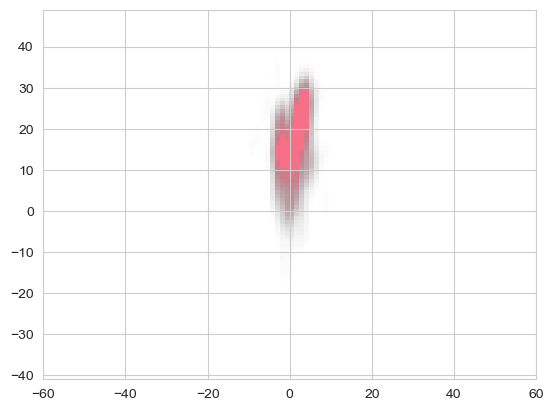

In [49]:
cmap = matplotlib.colors.ListedColormap(['#00000000', subj_color])
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#00000000",subj_color,subj_color])
plt.imshow(np.rot90(Z),cmap = cmap,extent=[-60,60,-41,49])

In [43]:
subj_color

(0.9677975592919913, 0.44127456009157356, 0.5358103155058701)